<a href="https://colab.research.google.com/github/VivianPita/lab_iagi/blob/main/Es_7_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Field test del MultiLayer Perceptron

Questo è il testo dell'esercitazione che dovrete completare per questa settimana. Non sarà guidato passo passo, ma
dovrete usare quello che avete imparato negli altri jupyter notebooks per addestrare dei modelli e cross-validarli,
al massimo delle vostre capacità.
I tre esercizi da svolgere sono:

1. addestrare un MLP su [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Potete utilizzare il codice
 del precedente notebook, ma vi consiglio di riscriverlo in maniera più ordinata. In questo caso, fate prima
 un'analisi dei dati per capire con cosa avete a che fare.
2. addestrare un MLP su [YearPredictionMSD](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD): l'idea di
      questo esercizio è quella di utilizzare una rete neurale per migliorare le performance rispetto alla soluzione
      che avete già implementato con la logistic regression nell'[esercitazione 6](https://github.com/Sapienza-AI-Lab/esercitazione6-22-23). In questo caso l'aspetto che ci
      preme esplorare è l'efficacia del MLP nell'imparare una rappresentazione (i.e. delle features) migliore per la
      classifcazione, o la regressione. Questo esercizion non è banale e sono interessato a vedere come sfrutterete
      le reti neurali per migliorare le prestazioni. Se non avete fatto l'EDA durante la scorsa esercitazione, questo è il momento di farla.
3. addestrare un MLP su CIFAR-10: riprenderemo questo dataset anche con le reti convoluzionali, ma iniziamo a
      farci un'idea delle sue caratterisitche addestrando im modello migliore possibile utilizzando un MLP. La sfida
      in questo caso sarà la dimensionalità dell'input, e quindi delle connessioni del MLP.


In tutti i casi tenete conto di questi aspetti:
* Non siete costretti ad usare i notebook. Personalmente non li amo, ma sono adatti a presentare il codice per la
    didattica. Per lavorare con progetti di una certa complessità è spesso meglio passare ad un normale progetto
    python. Ovviamente se non avete una GPU nel vostro portatile/desktop, l'unica soluzione è colab.
* Utilizzate tensorboard o weight and biases per la visualizzazione e per fare il debug del vostro modello. Non provate le cose a caso.


###LIBRERIE + MODEL SET UP


In [10]:
#importo le varie librerie
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sklearn
import time
from sklearn.model_selection import train_test_split

In [2]:
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.fc1=nn.Linear(input_size,hidden_size)
    self.fc2=nn.Linear(hidden_size,output_size)
  def forward(self,x):
    x=self.fc1(x)
    x=F.relu(x)
    x=self.fc2(x)
    return x

In [3]:
def train(model, device, optimizer, loss_fn, epochs, train_loader, validation_loader):
    model.train()
    train_losses = []
    validation_losses = []

    for epoch in range(epochs):
        total_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item()
                ))
        train_losses.append(total_loss / len(train_loader))

        total_loss = 0
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = model(data) #validation using the model with the updated weights and biases from the training
            loss = loss_fn(output, target)
            total_loss += loss.item()
        validation_losses.append(total_loss / len(validation_loader))

    return train_losses, validation_losses

In [4]:
def test(model, device, loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): #no need to calculate the gradients when testing
        for data, target in loader: #loader is the test_loader
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = model(data) #do not calculate the gradients because of the line with torch.no_grad()
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True) #keep dim for example is [[1], [2]] instead of [1, 2]
            correct += pred.eq(target.view_as(pred)).sum().item() #sum up the correct predictions
    test_loss /= len(loader.dataset)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss,
        correct,
        len(loader.dataset),
        100. * correct / len(loader.dataset)
    ))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###FASHIONMNIST

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(x.shape[0], -1))
])

train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
validation_and_test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

validation_set, test_set = torch.utils.data.random_split(validation_and_test_set, [len(validation_and_test_set)//2, len(validation_and_test_set)//2])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12855909.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 227770.96it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4294893.68it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14779108.14it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



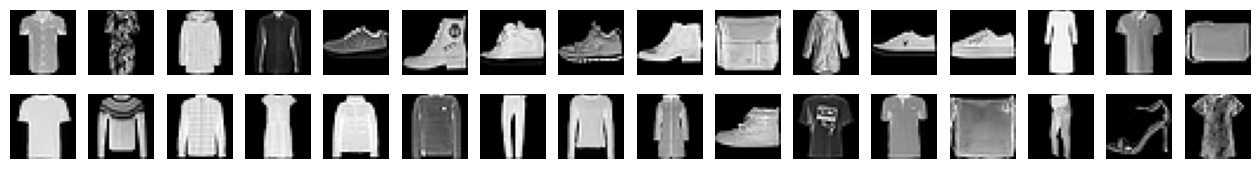

In [7]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(16, 2))
for i in range(32):
    plt.subplot(2, 16, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [8]:
model = MLP(28*28, 100, 10).to(device) #moves the model to Cuda if available
optimizer = optim.Adam(model.parameters()) #update the weights and biases during training, Adam algorithm (a variant of gradient descent)
loss = nn.CrossEntropyLoss()

In [11]:
train_losses, validation_losses = train(model, device, optimizer, loss, 10, train_loader, validation_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.336673
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.173535
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.262113
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.373842
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.432611
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.325166
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.244060
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.211474
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.256038
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.281363
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.158505
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.287054
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.175129
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.290793
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.115254
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.235540
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.363097
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.259214
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.225032
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.345521
Train Epoch:

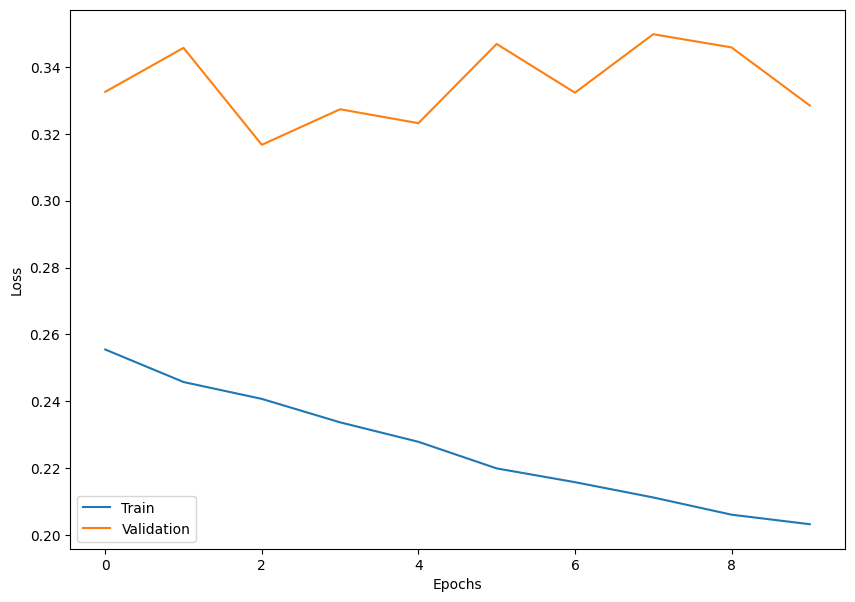

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
test(model, device, test_loader, loss)

Average loss: 0.0054, Accuracy: 4387/5000 (88%)


###YEARPREDICTION


In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
df = pd.read_csv(url, header=None, compression='zip', sep=',')[:1000]
df.head()
df.info()
df=df.dropna()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 91 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   int64  
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   float64
 11  11      1000 non-null   float64
 12  12      1000 non-null   float64
 13  13      1000 non-null   float64
 14  14      1000 non-null   float64
 15  15      1000 non-null   float64
 16  16      1000 non-null   float64
 17  17      1000 non-null   float64
 18  18      1000 non-null   float64
 19  19      1000 non-null   float64
 20  20      1000 non-null   float64
 21  21      1000 non-null   float64
 22  2

In [17]:
df = np.array(df)
x = df[:, 1:]
y = df[: , 0]
y = pd.Categorical(y, ordered=True).codes

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
#standardize to make different features comparable
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [18]:
class DatasetYearPrediction(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [19]:
train_set = DatasetYearPrediction(x_train, y_train)
validation_set = DatasetYearPrediction(x_validation, y_validation)
test_set = DatasetYearPrediction(x_test, y_test)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [32]:
model = MLP(90, 128, max(y_train)+1).to(device) #+1 because the classes start at 0
optimizer = optim.Adam(model.parameters(),lr=0.01)
loss = nn.CrossEntropyLoss()

In [33]:
train_losses, validation_losses = train(model, device, optimizer, loss, 10, train_loader, validation_loader)

Train Epoch: 0 [0/800 (0%)]	Loss: 3.963500
Train Epoch: 1 [0/800 (0%)]	Loss: 3.233964
Train Epoch: 2 [0/800 (0%)]	Loss: 3.018422
Train Epoch: 3 [0/800 (0%)]	Loss: 2.396610
Train Epoch: 4 [0/800 (0%)]	Loss: 2.428711
Train Epoch: 5 [0/800 (0%)]	Loss: 2.295647
Train Epoch: 6 [0/800 (0%)]	Loss: 2.005451
Train Epoch: 7 [0/800 (0%)]	Loss: 1.804159
Train Epoch: 8 [0/800 (0%)]	Loss: 1.950064
Train Epoch: 9 [0/800 (0%)]	Loss: 1.543346


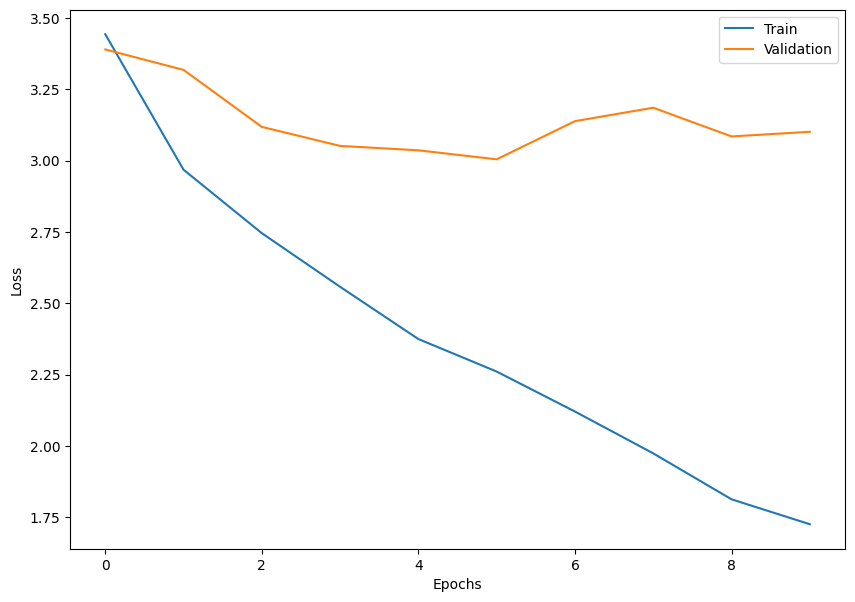

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
test(model, device, test_loader, loss)

Average loss: 0.0529, Accuracy: 36/100 (36%)


###CIFAR-10

In [48]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Carica il dataset CIFAR-10 e crea i DataLoader per il set di addestramento e test
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2, len(testset)//2])
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
validationloader = DataLoader(validationset, batch_size=64, shuffle=True)

# Definisci l'architettura del MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # appiattisce l'input in un vettore
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inizializza il modello, la funzione di perdita e l'ottimizzatore
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestra il modello
epochs = 10
train_losses = []
validation_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    train_losses.append(running_loss / len(trainloader))
    total_loss = 0
    for data, target in validationloader:
      data, target = data.to(device), target.to(device)
      data = data.view(data.shape[0], -1)
      output = model(data) #validation using the model with the updated weights and biases from the training
      loss = criterion(output, target)
      total_loss += loss.item()
    validation_losses.append(total_loss / len(validationloader))

print('Finished Training')

# Valuta il modello sul set di test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Files already downloaded and verified
[1,   100] loss: 1.879
[1,   200] loss: 1.721
[1,   300] loss: 1.654
[1,   400] loss: 1.622
[1,   500] loss: 1.594
[1,   600] loss: 1.557
[1,   700] loss: 1.539
[2,   100] loss: 1.435
[2,   200] loss: 1.437
[2,   300] loss: 1.434
[2,   400] loss: 1.438
[2,   500] loss: 1.422
[2,   600] loss: 1.434
[2,   700] loss: 1.398
[3,   100] loss: 1.305
[3,   200] loss: 1.284
[3,   300] loss: 1.333
[3,   400] loss: 1.316
[3,   500] loss: 1.333
[3,   600] loss: 1.306
[3,   700] loss: 1.330
[4,   100] loss: 1.169
[4,   200] loss: 1.223
[4,   300] loss: 1.220
[4,   400] loss: 1.213
[4,   500] loss: 1.243
[4,   600] loss: 1.247
[4,   700] loss: 1.216
[5,   100] loss: 1.113
[5,   200] loss: 1.115
[5,   300] loss: 1.117
[5,   400] loss: 1.120
[5,   500] loss: 1.142
[5,   600] loss: 1.187
[5,   700] loss: 1.158
[6,   100] loss: 1.037
[6,   200] loss: 1.032
[6,   300] loss: 1.076
[6,   400] loss: 1.071
[6,   500] loss: 1.089
[6, 